In [2]:
#importando bibliotecas necessárias no projeto
from sklearn import svm
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.client import device_lib
from sklearn.svm import SVC
from keras import utils as np_utils
from keras import backend
import tensorflow as tf
import numpy as np
import csv
import matplotlib.pyplot as plt
from re import search
import numpy as np
from subprocess import getoutput as gop
import glob
import pandas as pd
import csv
import random

C:\Users\Elaine\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Carregando conjuntos de treino e teste

In [3]:
# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
}

def load_data(dataset):
    ch_names = []
    create_ch_name = False
    
    data_dir = gop('ls {}'.format(folders[dataset])).split('\n')
    # 1ª dimensão dos dados contendo os sujeitos
    subjects = list()
    subjects_alc = list()
    subjects_ctrl = list()
    
    for types in data_dir:
        files = gop('ls {}/{}'.format(folders[dataset], types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials = list()
        is_alc = True
        
        for f in files:
            arquivo = open('{}/{}/{}'.format(folders[dataset], types, f))
            text = arquivo.readlines()
            
            alc = search('co2a', text[0])
            ctrl = search('co2c', text[0])
            
            if ctrl:
                is_alc = False
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            for line in text:
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)
                                    
                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        chs.append(values)
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())
            
            create_ch_name = True
            chs.append(values)
            trials.append(chs)
            arquivo.close()
            
        if is_alc:
            subjects_alc.append(trials)
            md_alc = np.average(trials, axis=0)
        else:
            subjects_ctrl.append(trials)
            md_ctrl = np.average(trials, axis=0)
            
    data_alc = np.array(subjects_alc)
    data_ctrl = np.array(subjects_ctrl)
    
#     data.tofile('./dataset_csv/small_data.csv', sep=',', newline='')   
    return data_alc, md_alc, data_ctrl, md_ctrl, ch_names


In [4]:
data_alc, md_alc, data_ctrl, md_ctrl, ch_names = load_data('large_train')
data_alc_test, md_alc_test, data_ctrl_test, md_ctrl_test, ch_names_test = load_data('large_test')

In [5]:
#Treino

y_md_alc = []
count = 0
for i in range(len(md_alc)):
    y_md_alc.insert(count, True)
    count += 1

y_md_ctrl = []
count = 0
for i in range(len(md_ctrl)):
    y_md_ctrl.insert(count, False)
    count += 1

md_total = np.concatenate((md_alc, md_ctrl))
y_md_total = np.concatenate((y_md_alc, y_md_ctrl))

#Teste

y_md_alc_test = []
count = 0
for i in range(len(md_alc_test)):
    y_md_alc_test.insert(count, True)
    count += 1

y_md_ctrl_test = []
count = 0
for i in range(len(md_ctrl_test)):
    y_md_ctrl_test.insert(count, False)
    count += 1
    
md_total_test = np.concatenate((md_alc_test, md_ctrl_test))
y_md_total_test = np.concatenate((y_md_alc_test, y_md_ctrl_test))


md_array = []
md_total_com_y = []
count = 0
count_md = 0
i = 0
for item in md_total:
    for subitem in item:
        md_total_com_y.insert(count, subitem)
        count += 1
    md_total_com_y.insert(count, y_md_total[i])
    count = 0
    md_array.insert(count_md, md_total_com_y)
    md_total_com_y = []
    count_md += 1
    i += 1

    
test_array = []
test_total_com_y = []
count = 0
count_test = 0
i = 0
for item in md_total_test:
    for subitem in item:
        test_total_com_y.insert(count, subitem)
        count += 1
    test_total_com_y.insert(count, y_md_total_test[i])
    count = 0
    test_array.insert(count_test, test_total_com_y)
    test_total_com_y = []
    count_test += 1
    i += 1

In [6]:
random.shuffle(md_array)
random.shuffle(test_array)

index = 0
y_train = []
for i in range(len(md_array)):
    result = md_array[i][256] #Vetor de resultados
    y_train.insert(index, result)
    index += 1

for i in range(len(md_array)):
    del(md_array[i][256])

x_train = md_array
y_train = y_train
print(len(md_array[0]))
print(y_train)

index = 0
y_test = []
for i in range(len(test_array)):
    result = test_array[i][256] #Vetor de resultados
    y_test.insert(index, result)
    index += 1

for i in range(len(test_array)):
    del(test_array[i][256])

x_test = test_array
y_test = y_test
print(x_test[0])
print(y_test)

256
[False, True, True, False, False, False, False, True, False, True, False, True, True, True, True, False, True, False, True, False, True, False, False, True, True, False, False, False, False, True, False, True, True, True, False, True, False, False, False, False, True, True, True, True, False, False, True, True, False, True, False, False, True, True, True, False, False, False, True, False, False, False, False, False, True, False, True, False, True, True, True, False, False, True, False, True, True, False, False, True, False, True, True, True, False, True, False, False, False, True, True, True, True, False, True, True, False, True, False, True, False, False, False, True, True, True, False, False, True, True, False, True, True, False, True, False, False, True, True, False, True, False, True, False, False, False, True, True]
[1.8056333333333332, 2.179966666666666, 1.5614999999999999, 0.5198, 0.03153333333333356, 0.5849666666666666, 1.9195333333333333, 3.1403666666666656, 3.3518, 2.7496

### Modelo de rede neural

Train on 89 samples, validate on 39 samples
Epoch 1/30
89/89 [==============================] - 19s 210ms/step - loss: 0.6273 - acc: 0.8427 - val_loss: 0.1352 - val_acc: 0.9487
Epoch 2/30
89/89 [==============================] - 0s 527us/step - loss: 0.1672 - acc: 0.9101 - val_loss: 0.0275 - val_acc: 1.0000
Epoch 3/30
89/89 [==============================] - 0s 424us/step - loss: 0.0558 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 4/30
89/89 [==============================] - 0s 527us/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.0101 - val_acc: 1.0000
Epoch 5/30
89/89 [==============================] - 0s 600us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 1.0000
Epoch 6/30
89/89 [==============================] - 0s 527us/step - loss: 0.0141 - acc: 1.0000 - val_loss: 0.0098 - val_acc: 1.0000
Epoch 7/30
89/89 [==============================] - 0s 351us/step - loss: 0.0111 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 8/30
89/89 [=============

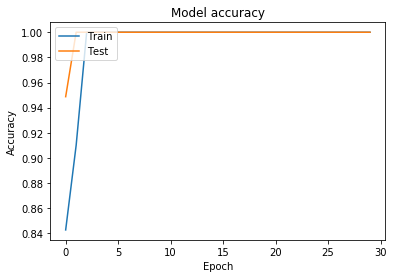

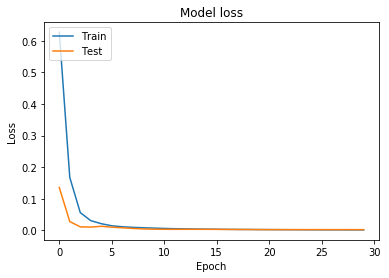

In [7]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=256))
model.add(Dense(units=59, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(x_train, y_train, validation_split=0.30, epochs=30, batch_size=16, verbose=1)

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=16)
#print("\n Taxa de acerto: %.2f%%" % (loss_and_metrics[1]*100))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#print("\n Função de Custo: %.2f%%" % (loss_and_metrics[0]))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
